### Homemade Python GP implementation 
---

By Paul Duckworth

Clearly, the book to look at is Chapter 2 of [Rasmussen and Williams 2006](http://www.gaussianprocess.org/gpml/chapters/RW.pdf), plus other useful material on GPs can be found in [these](https://www.youtube.com/watch?v=MfHKW5z-OOA&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=9) video lectures, with Gaussian Basics described [here](https://www.youtube.com/watch?v=4vGiHC35j9s&index=8&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6).

A Gaussian Distribution: $$ \boldsymbol{f} = (f_1, \dots, f_n) \sim \mathcal{N}(\mu, \Sigma), \text{ for 
} i = 1, \dots, n.$$

A Gaussian Process: $$ f(\boldsymbol{x}) = GP(m(\boldsymbol{x}), k(\boldsymbol{x}, \boldsymbol{x}')),$$

with mean function:
$$m(\boldsymbol{x}) = \mathbb{E}[f(\boldsymbol{x})],$$ 

and covariance function: 
$$k(\boldsymbol{x}, \boldsymbol{x}') = \mathbb{E}[ (f(\boldsymbol{x}) - m(\boldsymbol{x})) - (f(\boldsymbol{x'}) - m(\boldsymbol{x'}))^{T}]. $$

**Definition**: A GP is a colleciton of random variables, any finite number of which have a consistent Gaussian Distribution. 

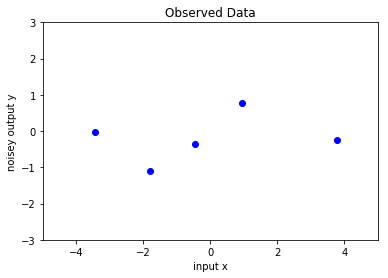

In [160]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

# We first need a true (and unknown) function with which to approximate using a GP:
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()

# We need some observed data points from that function: 

N = 5            # number of training points.
s = 0.1          # noise variance.

# Sample some input points and noisy versions of the function evaluated at these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

plt.scatter(X, y, c= "b")
plt.xlabel("input x"), plt.ylabel("noisey output y"), plt.title("Observed Data")
plt.axis([-5, 5, -3, 3])
plt.show()

In [161]:
# Define the x-axis points that we're going to make predictions at. 
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

Kernel
---

First, specify a kernel, such as an exponentiated quadratic kernel (RBF): 

$$ k(x, x') = \sigma^{2}_{f} exp (-\frac{1}{2l^2}(x - x')^2), $$ 
where $\sigma$ is the variance and $l$ the length hyperparameter.

The kernel specifies the prior belief that we want smooth functions, i.e. close by x's are close in y. 

In [162]:
def kernel(a,b):
    """GP squared exponential kernel with sigma = 1"""
    length_param = 1.0
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/length_param) * sqdist)

def annotate(K):
    """Annotate confusion matrix with values"""
    width, height = K.shape
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate("%0.2f" % K[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center')

K = kernel(X, X)
Kstar= kernel(X, Xtest)
Kstarstar = kernel(Xtest, Xtest)

button_k    = widgets.Button(description="Plot Kernel")
button_off  = widgets.Button(description="Hide Kernel")

display(button_k), display(button_off)    # dislay the two buttons

def on_button_clicked(a): 
    clear_output()
    plt.imshow(K, interpolation='nearest')#, cmap=plt.cm.Blues)
    annotate(K)   # don't annotate cells :) 
    plt.colorbar()
    plt.show()

def off_button_clicked(a): clear_output()

button_k.on_click(on_button_clicked)
button_off.on_click(off_button_clicked)

Prior
---

Define a range of test points along x-axis, and use the kernel and the cholesky decomposition (for inverting K), in order to draw samples from the prior using:
$$f_i \sim \mathcal{N}(0_N, K_{N \times N}),$$
where 
$$K_{N \times N} = k(X, X). $$

This defines a positive definite matrix $K$ which can be decomposed: $$ K = LL^T,$$ leading to: $$f_i \sim \mathcal{N}(0_N, I_{N\times N})\times L ,$$
where $L$ is a lower tri-matrix from the cholesky decomposition. 


In [163]:
### draw samples from the prior at test points

L = np.linalg.cholesky(Kstarstar + 1e-6*np.eye(n))

button_prior = widgets.Button(description="Draws from Prior")
button_off  = widgets.Button(description="Hide Priors")

display(button_prior), display(button_off)    # dislay the two buttons

def plot_prior(f_prior):
    plt.plot(Xtest, f_prior)
    plt.title("Three samples from the GP prior"), plt.xlabel('x'), plt.ylabel("k(x,x')")
    plt.show()

def on_button_clicked(a): 
    rand = np.random.normal(size=(n,3))         # random draws of length n
    f_prior = np.dot(L, rand)
    plt.clf()
    plt.axis([-5, 5, -3, 3])
    plot_prior(f_prior)

def off_button_clicked(a): 
    clear_output()

button_prior.on_click(on_button_clicked)
button_off.on_click(off_button_clicked)

Posterior 
---

Given some data $\mathcal{D} = \{ (\boldsymbol{x}_i, f_i), i = 1:N\}$ where $ f_i = f(\boldsymbol{x}_i)$. 

Then the noise-free joint distribution of the training outputs $\boldsymbol{f}$ and the test outputs $\boldsymbol{f_{*}}$can be specified as:

$$
\begin{pmatrix} 
\boldsymbol{f}   \\ 
\boldsymbol{f}_{*}  \\ 
\end{pmatrix} \sim \mathcal{N} 
\begin{pmatrix} 
    \begin{pmatrix} 
        \boldsymbol{\mu}   \\ 
        \boldsymbol{\mu}_{*}  \\ 
    \end{pmatrix},
    \begin{pmatrix} 
        K       &  K_{*}  \\ 
        K_{*}^T &  K_{**} \\ 
    \end{pmatrix}
\end{pmatrix}
$$

Then the posterior is defined by conditioning on the observed data $\mathcal{D}$: 

$$
p(\boldsymbol{f}_{*} \mid X_{*}, X, \boldsymbol{f})  = 
    \mathcal{N}(\boldsymbol{f}_{*} \mid \boldsymbol{\mu}_{*}, \Sigma_{*}), 
$$
    
where:
$$
\begin{align}    
\boldsymbol{\mu}_{*} & =  \boldsymbol{\mu}(X_{*}) + K_{*}^T K^{-1} (\boldsymbol{f} - \boldsymbol{\mu}(X))\\
\Sigma_{*}           & = K_{**} - K_{*}^T K^{-1}K_{*}
\end{align}
$$


With added noise on the observed training points, this joint distribution can be altered to: 

$$
\begin{pmatrix} 
\boldsymbol{y}   \\ 
\boldsymbol{f}_{*}  \\ 
\end{pmatrix} \sim \mathcal{N} 
\begin{pmatrix} 
    \begin{pmatrix} 
        \boldsymbol{\mu}   \\ 
        \boldsymbol{\mu}_{*}  \\ 
    \end{pmatrix},
    \begin{pmatrix} 
        K + \sigma_n^2 I      &  K_{*}  \\ 
        K_{*}^T &  K_{**}\\
    \end{pmatrix}
\end{pmatrix}, 
$$
where $y = f(\boldsymbol{x}) + \epsilon$ where there is added iid Gaussian noise $\epsilon$ with variance $\sigma_n^2 I$. 

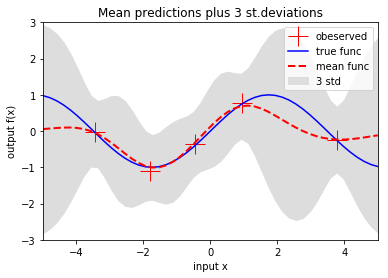

In [166]:
# compute the mean at each of our (x-axis) test points.

# decompose K (instead of inversion)
L = np.linalg.cholesky(K + s*np.eye(N))   # Notice the gaussian noise term added to K. (Ky)

# solve for m where: L*m = y
m = np.linalg.solve(L, y)

# solve for alpha where: L.T*alpha = m
alpha = np.linalg.solve(L.T, m)

mu = np.dot(Kstar.T, alpha)

plt.plot(X, y, 'r+', ms=20)             # 10 observed data points  (red)
plt.plot(Xtest, f(Xtest), 'b-')         # actual true process creating the data (blue)
plt.plot(Xtest, mu, 'r--', lw=2)       # mean function \mu   (red)
plt.axis([-5, 5, -3, 3])

# compute the variance at our test points - each point along the x-axis.

# solve for v where: Lv = Kstar
v = np.linalg.solve(L, Kstar)  

var = np.diag(Kstarstar) - np.sum(v**2, axis=0)
std = np.sqrt(var)
plt.gca().fill_between(Xtest.flat, mu-3*std, mu+3*std, color="#dddddd")

plt.xlabel('input x'),plt.ylabel('output f(x)')
plt.legend(['obeserved', 'true func', 'mean func', '3 std'])
plt.title('Mean predictions plus 3 st.deviations')

plt.show()

Let's explain what we just did: 
--- 

Since, the mean function $\boldsymbol{\mu}_{*} =  \boldsymbol{\mu}(X_{*}) + K_{*}^T K^{-1} (\boldsymbol{f} - \boldsymbol{\mu}(X))$ but we don't want to invert K we do the following: 

Cholesky says: $K = LL^T$ and Inverse Cholesky: $ K^{-1}y = L^{-T}L^{-1}y$. 

So, we let $\alpha = K^{-1} \boldsymbol{f}$, then $\boldsymbol{\mu}_{*} = K_{*}^T  \alpha$ when we are assuming a zero mean function.

Then, we let $m = L^{-1} \boldsymbol{f}$ and if that's true, it follows that $ Lm = \boldsymbol{f}$, and so we solve for $m$. 

Then, if $\alpha = K^{-1} \boldsymbol{f} = L^{-T}L^{-1}\boldsymbol{f} = L^{-T} m$, then it also follows that $L^{T}\alpha = m$ and so we solve for $\alpha$.


For the Variance,  $Var[\boldsymbol{f_{*}}] = K_{**} - K_{*}^T K^{-1}K_{*}$, again letting $K^{-1} = L^{-T}L^{-1}$, so $K_{*}^T K^{-1}K_{*} = (K_{*}^T L^{-T}) (L^{-1} K_{*})$ where we can solve for $\boldsymbol{v}$ in $L\boldsymbol{v} = K_{*}$ and reduce to $\boldsymbol{v}^{T}\boldsymbol{v}$. 



Predictive Distribution
---

Commonly a zero mean function is used, and the key predictive equations for GPs reduce to:

$$
p(\boldsymbol{f}_{*} \mid X_{*}, X, \boldsymbol{y}) = 
    \mathcal{N}(\boldsymbol{\bar f}_{*}, cov(\boldsymbol{f}_{*})), 
$$

where:
$$
\begin{align}    
\boldsymbol{\bar f}_{*} &  = \mathbb{E}[\boldsymbol{f}_{*} \mid X, \boldsymbol{y}, X_{*}] = 
  K_{*}^T[K + \sigma^2_n I]^{-1}\boldsymbol{y} , \\
cov(\boldsymbol{f}_{*}) & = K_{**} - K_{*}^T [K + \sigma^2_n I]^{-1}K_{*}. 
\end{align}
$$




Draw samples from posterior
--- 

From $
p(\boldsymbol{f}_{*} \mid X_{*}, X, \boldsymbol{f})  = 
    \mathcal{N}(\boldsymbol{f}_{*} \mid \boldsymbol{\mu}_{*}, \Sigma_{*}), $ 
we can draw samples, by again using Cholesky factorisation, and a random number generator. 


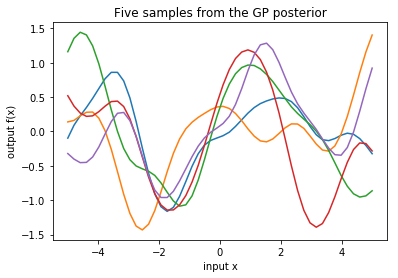

In [167]:
# Draw samples from the posterior - at our test points.
post = Kstarstar + 1e-6*np.eye(n) - np.dot(v.T, v)
L = np.linalg.cholesky(post)          
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,5)))

plt.clf()
plt.plot(Xtest, f_post)
plt.xlabel('input x'), plt.ylabel('output f(x)')
plt.title('Five samples from the GP posterior')
plt.show()

Log Marginal Likelihood
---

The marginal likelihood $p(\boldsymbol{y} \mid X)$ (or evidence) is the integral of the likelihood times prior: 
$$
p(\boldsymbol{y} \mid X) = \int p(\boldsymbol{y} \mid \boldsymbol{f}, X)p(\boldsymbol{f} \mid X) d\boldsymbol{f}.
$$

Given the prior is Gaussian: $\boldsymbol{f} \mid X \sim \mathcal{N}(0, K)$, and the likelihood is a factorised Gaussian: $ \boldsymbol{y} \mid \boldsymbol{f} \sim \mathcal{N}(\boldsymbol{f}, \sigma^2_n I) $, then it follows that the log marginal likelihood is also Gaussian: $ \boldsymbol{y} \sim \mathcal{N}(0, K + \sigma^2_n I) $, and is:
$$
log p(\boldsymbol{y} \mid X) = -\frac{1}{2}\boldsymbol{y}^T (K+\sigma^2_n I)^{-1} - \frac{1}{2}log \mid K+\sigma^2_n I \mid - \frac{n}{2}log2\pi .
$$

This can be computed: 
$$
 = -\frac{1}{2}\boldsymbol{y}^T\boldsymbol{\alpha} - \sum_i log L_{ii} - \frac{n}{2}log2\pi 
$$

In [168]:
LML = -0.5*y.T *alpha - sum(np.log(np.diag(L))) - 0.5*N*np.log(2*np.pi)
print LML

[ 232.0213273   232.56202656  232.52682713  232.25163029  232.52130912]


Optimisation
---

The hyperparameters of the kernel can be optimized by maximizing the log-marginal-likelihood (LML).

Note, the LML may have multiple local optima. 

Hyperparameters
---

We can vary the kernel hyperparameters and see what happens to the Prior and Posterior distributions...

In [169]:
def new_kernel(a,b,l=1.0,sig=1.0):
    """GP squared exponential kernel"""
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    k = (sig**2)*np.exp(-.5 * (1/l) * sqdist)
    return k

def wrap(length, sigma_f):
    K = new_kernel(X,X,length,sigma_f)
    Kstar = new_kernel(X, Xtest,length,sigma_f)
    Kstarstar = new_kernel(Xtest, Xtest,length,sigma_f)

    # draws from Prior distribution 
    L = np.linalg.cholesky(Kstarstar + s*np.eye(n))
    rand = np.random.normal(size=(n,3)) 
    f_prior = np.dot(L, rand)

    # compute the Posterior distribution (mean and covariance)
    L = np.linalg.cholesky(K + s*np.eye(N))
    m = np.linalg.solve(L, y)
    alpha = np.linalg.solve(L.T, m)
    mu = np.dot(Kstar.T, alpha)

    v = np.linalg.solve(L, Kstar)  
    var = np.diag(Kstarstar) - np.sum(v**2, axis=0)
    std = np.sqrt(var)

    # draws from Posterior distribution 
    post = Kstarstar + 1e-6*np.eye(n) - np.dot(v.T, v)
    L = np.linalg.cholesky(post)          
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,5)))
   

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    ax1.axis([-5, 5, -3, 3])
    ax1.set_xlabel("x"),ax1.set_ylabel("k(x,x')"), ax1.set_title("Three samples from the GP prior")
    ax1.plot(Xtest, f_prior)
    
    ax2.axis([-5, 5, -3, 3])
    ax2.plot(X, y, 'r+', ms=20)            
    ax2.plot(Xtest, f(Xtest), 'b-')        
    ax2.plot(Xtest, mu, 'r--', lw=2)
    ax2.fill_between(Xtest.flat, mu-3*std, mu+3*std, color="#dddddd")
    ax2.set_xlabel("x"), ax2.set_ylabel("f(x)"), ax2.set_title("Mean predictions plus 3 st.deviations")
    ax2.legend(['obeserved', 'true func', 'mean func', '3 std'])
    
    ax3.axis([-5, 5, -3, 3])
    ax3.plot(Xtest, f_post)
    ax3.set_xlabel("x"), ax2.set_ylabel("f(x)"), ax2.set_title("Five samples from the GP posterior")   

    plt.show()


interact(wrap, length=(0.01,10,0.01), sigma_f=(0.01,5,0.1));


Basis Function Interpretation
---

Given a single test point $\boldsymbol{x}_*$: 
$$
p(f_{*} \mid \boldsymbol{x}_{*}, X, \boldsymbol{y}) = 
    \mathcal{N}(f_{*} \mid K_{*}^T K_y^{-1}\boldsymbol{y}, k_{**} - K_{*}^T K_y^{-1}K_{*}), 
$$

where:
$K_y = K + \sigma^2_n I$ and often $ k_{**} = 1$. 

Then the mean can be re-written:

$$
\bar f_{*} = K_{*}^T K_y^{-1}\boldsymbol{y} = \sum_{i=1}^{N} \alpha_i k(\boldsymbol{x}_i, \boldsymbol{x}_*)
$$
where $\alpha = K_y^{-1}\boldsymbol{y}$ comprises of the training data. 

So the mean function is just a non-linear function of a combination of basis funcitons, each defined at a training sample.  